In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path = "/content/drive" + "/My Drive/" + "/content/drive/MyDrive/tumor/brain-mri"

print(path)

Mounted at /content/drive
/content/drive/My Drive//content/drive/MyDrive/tumor/brain-mri


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

# Source directories
train_source_dir = '/content/drive/My Drive/kaggle_3m/brain-mri/tumor/train'
test_source_dir = '/content/drive/My Drive/kaggle_3m/brain-mri/tumor/test'

# Destination directories
train_dest_dir = '/content/drive/My Drive/brain/train'
test_dest_dir = '/content/drive/My Drive/brain/test'

# Ensure the destination directories exist, create them if not
os.makedirs(train_dest_dir, exist_ok=True)
os.makedirs(test_dest_dir, exist_ok=True)

# Function to copy all files from source to destination
def copy_images(source_dir, dest_dir):
    files_copied = 0
    if not os.path.exists(source_dir):
        print(f"Source directory does not exist: {source_dir}")
        return

    for root, _, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith('.tif'):  # Check for .tif files (case-insensitive)
                src_path = os.path.join(root, file)
                dest_path = os.path.join(dest_dir, file)
                try:
                    shutil.copy2(src_path, dest_path)
                    files_copied += 1
                    print(f'Copied {src_path} to {dest_path}')
                except Exception as e:
                    print(f"Failed to copy {src_path} to {dest_path}: {e}")

    if files_copied == 0:
        print(f"No .tif files found in {source_dir}.")
    else:
        print(f"{files_copied} files successfully copied from {source_dir} to {dest_dir}")

# Copy images to train and test directories
copy_images(train_source_dir, train_dest_dir)
copy_images(test_source_dir, test_dest_dir)

print("Copy operation completed.")


Source directory does not exist: /content/drive/My Drive/kaggle_3m/brain-mri/tumor/train
Source directory does not exist: /content/drive/My Drive/kaggle_3m/brain-mri/tumor/test
Copy operation completed.


In [ ]:
import os
import shutil

# Source directories (Kaggle_3m repository paths)
train_source_dir = 'path/to/tumor/brain-mri/kaggle_3m/train'
test_source_dir = 'path/to/tumor/brain-mri/kaggle_3m/test'

# Destination directories (Brain repository paths)
train_dest_dir = 'path/to/brain/train'
test_dest_dir = 'path/to/brain/test'

# Ensure the destination directories exist, create them if not
os.makedirs(train_dest_dir, exist_ok=True)
os.makedirs(test_dest_dir, exist_ok=True)

# Function to copy .tif files from source to destination
def copy_tif_files(source_dir, dest_dir):
    for root, _, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith('.tif'):
                src_path = os.path.join(root, file)
                dest_path = os.path.join(dest_dir, file)
                shutil.copy2(src_path, dest_path)
                print(f'Copied {src_path} to {dest_path}')

# Copy .tif files from train and test source directories to the corresponding destination directories
copy_tif_files(train_source_dir, train_dest_dir)
copy_tif_files(test_source_dir, test_dest_dir)

print("Copy operation completed successfully.")

Copy operation completed successfully.


In [ ]:
# SEGMENTATION
# import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [ ]:
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40

    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    image_generator = img_gen.flow_from_dataframe(
        dataframe=df,
        x_col='images_paths',
        y_col='masks_paths',
        class_mode=None,
        color_mode='rgb',
        target_size=img_size,
        batch_size=batch_size
    )

    mask_generator = msk_gen.flow_from_dataframe(
        dataframe=df,
        x_col='images_paths',
        y_col='masks_paths',
        class_mode=None,
        color_mode='grayscale',
        target_size=img_size,
        batch_size=batch_size
    )

    gen = zip(image_generator, mask_generator)

    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

In [ ]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
import numpy as np
SEED = 42
np.random.seed = SEED

#UNZIP_PATH = '../input/data-science-bowl-2018/'
TRAIN_PATH = '/content/drive/MyDrive/tumor/brain-mri/kaggle_3m/train'
TEST_PATH = '/content/drive/MyDrive/tumor/brain-mri/kaggle_3m/test'

IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize

# Define constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
DATA_PATH = "/content/drive/MyDrive/tumor/brain-mri/kaggle_3m/train"  # Update with your actual path

# Get a list of subdirectories in the data path
subdirectories = [subdir for subdir in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, subdir))]

X_train = []
Y_train = []

# Loop through each subdirectory
for subdir in tqdm(subdirectories):
    subdir_path = os.path.join(DATA_PATH, subdir)
    # Get a list of image files in the current subdirectory
    image_files = [file for file in os.listdir(subdir_path) if file.endswith('.tif')]

    # Loop through each image file
    for image_file in image_files:
        # Read the image
        img = imread(os.path.join(subdir_path, image_file))

        # Check if the image is grayscale
        if len(img.shape) == 2:
            # If grayscale, convert it to RGB by stacking the image three times
            img = np.stack((img,) * 3, axis=-1)

        # Resize the image
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train.append(img)

        # Construct the corresponding mask file name
        mask_file = image_file.replace('.tif', '_mask.tif')

        # Check if the mask file exists
        if mask_file in os.listdir(subdir_path):
            # Read the mask
            mask = imread(os.path.join(subdir_path, mask_file))

            # Convert the mask to binary format (assuming it's grayscale)
            mask = (mask > 0).astype(np.uint8)  # Convert non-zero values to 1

            # Expand dimensions to match the image shape
            mask = np.expand_dims(mask, axis=-1)

            # Resize the mask
            mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            Y_train.append(mask)
        else:
            print(f"Mask file not found for image: {image_file}")

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Now X_train and Y_train should contain the images and masks respectively
print("Number of images:", len(X_train))
print("Number of masks:", len(Y_train))

  0%|          | 0/68 [00:00<?, ?it/s]

Mask file not found for image: TCGA_HT_8111_19980330_10_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_9_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_12_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_22_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_21_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_15_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_1_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_4_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_11_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_5_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_16_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_14_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_8_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_7_mask.tif
Mask file not found for image: TCGA_HT_8111_19980330_2_mask.tif
Mask file not found for image: T

  1%|▏         | 1/68 [00:43<48:14, 43.20s/it]

Mask file not found for image: TCGA_HT_8111_19980330_17_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_13_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_5_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_7_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_1_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_12_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_18_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_10_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_17_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_6_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_20_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_2_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_19_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_11_mask.tif
Mask file not found for image: TCGA_HT_8107_19980708_3_mask.tif
Mask file not found for image: 

  3%|▎         | 2/68 [01:15<40:09, 36.50s/it]

Mask file not found for image: TCGA_HT_8107_19980708_9_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_21_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_16_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_15_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_13_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_14_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_17_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_1_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_23_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_10_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_20_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_12_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_25_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_18_mask.tif
Mask file not found for image: TCGA_HT_A61B_19991127_22_mask.tif
Mask file not found for ima

  4%|▍         | 3/68 [01:27<27:26, 25.33s/it]

Mask file not found for image: TCGA_HT_A616_19991226_26_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_1_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_20_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_4_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_17_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_14_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_13_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_3_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_18_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_12_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_19_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_27_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_21_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_11_mask.tif
Mask file not found for image: TCGA_HT_A616_19991226_5_mask.tif
Mask file not found for image

  6%|▌         | 4/68 [02:12<35:25, 33.22s/it]

Mask file not found for image: TCGA_HT_A61A_20000127_2_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_17_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_24_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_33_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_28_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_20_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_1_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_35_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_23_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_26_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_14_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_32_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_15_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_10_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_39_mask.tif
Mask file not found for ima

  7%|▋         | 5/68 [02:29<28:46, 27.40s/it]

Mask file not found for image: TCGA_HT_A61A_20000127_80_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_76_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_78_mask.tif
Mask file not found for image: TCGA_HT_A61A_20000127_79_mask.tif
Mask file not found for image: TCGA_HT_8113_19930809_1_mask.tif
Mask file not found for image: TCGA_HT_8113_19930809_15_mask.tif
Mask file not found for image: TCGA_HT_8113_19930809_19_mask.tif
Mask file not found for image: TCGA_HT_8113_19930809_12_mask.tif
Mask file not found for image: TCGA_HT_8113_19930809_14_mask.tif
Mask file not found for image: TCGA_HT_8113_19930809_10_mask.tif
Mask file not found for image: TCGA_HT_8113_19930809_17_mask.tif
Mask file not found for image: TCGA_HT_8113_19930809_11_mask.tif
Mask file not found for image: TCGA_HT_8113_19930809_16_mask.tif
Mask file not found for image: TCGA_HT_8113_19930809_13_mask.tif
Mask file not found for image: TCGA_HT_8113_19930809_18_mask.tif
Mask file not found for im

  9%|▉         | 6/68 [03:04<30:54, 29.90s/it]

Mask file not found for image: TCGA_HT_8114_19981030_7_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_14_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_10_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_12_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_6_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_22_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_4_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_2_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_3_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_17_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_21_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_9_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_19_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_1_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_18_mask.tif
Mask file not found for image: T

 10%|█         | 7/68 [03:40<32:23, 31.86s/it]

Mask file not found for image: TCGA_HT_8114_19981030_20_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_15_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_11_mask.tif
Mask file not found for image: TCGA_HT_8114_19981030_5_mask.tif
Mask file not found for image: TCGA_HT_A5RC_19990831_26_mask.tif
Mask file not found for image: TCGA_HT_A5RC_19990831_14_mask.tif
Mask file not found for image: TCGA_HT_A5RC_19990831_20_mask.tif
Mask file not found for image: TCGA_HT_A5RC_19990831_17_mask.tif
Mask file not found for image: TCGA_HT_A5RC_19990831_25_mask.tif
Mask file not found for image: TCGA_HT_A5RC_19990831_12_mask.tif
Mask file not found for image: TCGA_HT_A5RC_19990831_13_mask.tif
Mask file not found for image: TCGA_HT_A5RC_19990831_16_mask.tif
Mask file not found for image: TCGA_HT_A5RC_19990831_11_mask.tif
Mask file not found for image: TCGA_HT_A5RC_19990831_22_mask.tif
Mask file not found for image: TCGA_HT_A5RC_19990831_24_mask.tif
Mask file not found for im

 12%|█▏        | 8/68 [04:31<37:57, 37.96s/it]

Mask file not found for image: TCGA_HT_8106_19970727_12_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_10_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_11_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_6_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_5_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_4_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_2_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_9_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_7_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_16_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_8_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_22_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_17_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_21_mask.tif
Mask file not found for image: TCGA_HT_8106_19970727_19_mask.tif
Mask file not found for image: T

 13%|█▎        | 9/68 [05:06<36:31, 37.15s/it]

Mask file not found for image: TCGA_HT_8105_19980826_6_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_32_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_5_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_10_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_12_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_15_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_2_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_8_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_20_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_11_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_22_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_31_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_29_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_30_mask.tif
Mask file not found for image: TCGA_HT_8105_19980826_16_mask.tif
Mask file not found for image

 15%|█▍        | 10/68 [05:58<40:25, 41.83s/it]

Mask file not found for image: TCGA_HT_7884_19980913_18_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_5_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_8_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_3_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_10_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_13_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_4_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_17_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_16_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_2_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_19_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_20_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_11_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_1_mask.tif
Mask file not found for image: TCGA_HT_7884_19980913_12_mask.tif
Mask file not found for image: 

 16%|█▌        | 11/68 [06:29<36:38, 38.58s/it]

Mask file not found for image: TCGA_HT_7884_19980913_9_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_16_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_14_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_13_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_17_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_11_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_12_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_1_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_19_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_10_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_15_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_18_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_9_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_6_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_3_mask.tif
Mask file not found for image:

 18%|█▊        | 12/68 [07:02<34:19, 36.78s/it]

Mask file not found for image: TCGA_HT_7874_19950902_20_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_4_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_7_mask.tif
Mask file not found for image: TCGA_HT_7874_19950902_5_mask.tif
Mask file not found for image: TCGA_HT_7860_19960513_14_mask.tif
Mask file not found for image: TCGA_HT_7860_19960513_6_mask.tif
Mask file not found for image: TCGA_HT_7860_19960513_5_mask.tif
Mask file not found for image: TCGA_HT_7860_19960513_20_mask.tif
Mask file not found for image: TCGA_HT_7860_19960513_4_mask.tif
Mask file not found for image: TCGA_HT_7860_19960513_19_mask.tif
Mask file not found for image: TCGA_HT_7860_19960513_1_mask.tif
Mask file not found for image: TCGA_HT_7860_19960513_7_mask.tif
Mask file not found for image: TCGA_HT_7860_19960513_17_mask.tif
Mask file not found for image: TCGA_HT_7860_19960513_12_mask.tif
Mask file not found for image: TCGA_HT_7860_19960513_10_mask.tif
Mask file not found for image: TC

 19%|█▉        | 13/68 [07:37<33:02, 36.05s/it]

Mask file not found for image: TCGA_HT_7882_19970125_4_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_28_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_6_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_16_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_17_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_21_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_8_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_2_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_15_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_3_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_29_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_20_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_12_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_31_mask.tif
Mask file not found for image: TCGA_HT_7882_19970125_7_mask.tif
Mask file not found for image: 

 21%|██        | 14/68 [08:29<36:46, 40.86s/it]

Mask file not found for image: TCGA_HT_7877_19980917_2_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_24_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_10_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_14_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_19_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_21_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_26_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_3_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_30_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_18_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_27_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_29_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_13_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_4_mask.tif
Mask file not found for image: TCGA_HT_7877_19980917_12_mask.tif
Mask file not found for imag

 22%|██▏       | 15/68 [09:16<37:50, 42.84s/it]

Mask file not found for image: TCGA_HT_7877_19980917_8_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_6_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_10_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_8_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_14_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_27_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_16_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_19_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_11_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_20_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_15_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_7_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_23_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_21_mask.tif
Mask file not found for image: TCGA_HT_7879_19981009_26_mask.tif
Mask file not found for image

 24%|██▎       | 16/68 [10:02<37:54, 43.74s/it]

Mask file not found for image: TCGA_HT_7879_19981009_3_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_16_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_8_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_14_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_18_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_19_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_11_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_20_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_6_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_12_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_13_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_1_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_15_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_2_mask.tif
Mask file not found for image: TCGA_HT_8018_19970411_5_mask.tif
Mask file not found for image: 

 25%|██▌       | 17/68 [10:34<34:06, 40.14s/it]

Mask file not found for image: TCGA_HT_7881_19981015_12_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_10_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_11_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_28_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_22_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_19_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_35_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_16_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_39_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_38_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_21_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_41_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_29_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_31_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_1_mask.tif
Mask file not found for im

 26%|██▋       | 18/68 [10:47<26:53, 32.27s/it]

Mask file not found for image: TCGA_HT_7881_19981015_8_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_9_mask.tif
Mask file not found for image: TCGA_HT_7881_19981015_7_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_16_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_13_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_17_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_15_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_23_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_12_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_10_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_2_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_21_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_25_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_22_mask.tif
Mask file not found for image: TCGA_HT_7856_19950831_26_mask.tif
Mask file not found for image

 28%|██▊       | 19/68 [11:39<31:09, 38.15s/it]

Mask file not found for image: TCGA_HT_7855_19951020_19_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_14_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_16_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_11_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_15_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_12_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_18_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_1_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_10_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_13_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_17_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_6_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_5_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_3_mask.tif
Mask file not found for image: TCGA_HT_7855_19951020_7_mask.tif
Mask file not found for image:

 29%|██▉       | 20/68 [12:14<29:40, 37.10s/it]

Mask file not found for image: TCGA_HT_7680_19970202_14_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_10_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_6_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_12_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_2_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_20_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_17_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_5_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_19_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_1_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_18_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_16_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_3_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_13_mask.tif
Mask file not found for image: TCGA_HT_7680_19970202_11_mask.tif
Mask file not found for image:

 31%|███       | 21/68 [12:47<28:02, 35.81s/it]

Mask file not found for image: TCGA_HT_7680_19970202_8_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_21_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_1_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_13_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_19_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_17_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_14_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_16_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_11_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_12_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_10_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_4_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_15_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_20_mask.tif
Mask file not found for image: TCGA_HT_7693_19950520_3_mask.tif
Mask file not found for image

 32%|███▏      | 22/68 [13:20<26:45, 34.89s/it]

Mask file not found for image: TCGA_HT_7684_19950816_17_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_8_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_16_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_2_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_22_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_19_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_25_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_18_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_9_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_10_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_4_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_3_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_24_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_1_mask.tif
Mask file not found for image: TCGA_HT_7684_19950816_12_mask.tif
Mask file not found for image: 

 34%|███▍      | 23/68 [14:01<27:35, 36.79s/it]

Mask file not found for image: TCGA_HT_7690_19960312_20_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_23_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_24_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_5_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_4_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_2_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_12_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_10_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_22_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_13_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_15_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_18_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_17_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_14_mask.tif
Mask file not found for image: TCGA_HT_7690_19960312_3_mask.tif
Mask file not found for image

 35%|███▌      | 24/68 [14:39<27:22, 37.33s/it]

Mask file not found for image: TCGA_HT_7616_19940813_16_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_19_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_12_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_14_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_18_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_11_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_17_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_15_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_10_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_1_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_13_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_22_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_25_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_21_mask.tif
Mask file not found for image: TCGA_HT_7616_19940813_23_mask.tif
Mask file not found for im

 37%|███▋      | 25/68 [15:29<29:19, 40.92s/it]

Mask file not found for image: TCGA_HT_7686_19950629_14_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_16_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_10_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_15_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_13_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_12_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_11_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_17_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_9_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_5_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_4_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_19_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_6_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_18_mask.tif
Mask file not found for image: TCGA_HT_7686_19950629_3_mask.tif
Mask file not found for image:

 38%|███▊      | 26/68 [16:01<26:56, 38.48s/it]

Mask file not found for image: TCGA_HT_7608_19940304_10_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_11_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_12_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_7_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_27_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_21_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_19_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_3_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_1_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_4_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_28_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_22_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_13_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_5_mask.tif
Mask file not found for image: TCGA_HT_7608_19940304_16_mask.tif
Mask file not found for image:

 40%|███▉      | 27/68 [16:47<27:39, 40.48s/it]

Mask file not found for image: TCGA_HT_7692_19960724_13_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_6_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_9_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_14_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_18_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_8_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_5_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_2_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_11_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_12_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_1_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_19_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_17_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_20_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_10_mask.tif
Mask file not found for image: 

 41%|████      | 28/68 [17:17<25:01, 37.55s/it]

Mask file not found for image: TCGA_HT_7692_19960724_7_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_3_mask.tif
Mask file not found for image: TCGA_HT_7692_19960724_16_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_16_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_2_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_10_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_6_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_12_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_13_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_14_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_5_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_18_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_7_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_20_mask.tif
Mask file not found for image: TCGA_HT_7694_19950404_9_mask.tif
Mask file not found for image: T

 43%|████▎     | 29/68 [17:53<24:07, 37.11s/it]

Mask file not found for image: TCGA_HT_7694_19950404_21_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_20_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_19_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_15_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_3_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_23_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_14_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_30_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_5_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_28_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_8_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_29_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_27_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_12_mask.tif
Mask file not found for image: TCGA_HT_7605_19950916_24_mask.tif
Mask file not found for imag

 44%|████▍     | 30/68 [18:44<26:09, 41.30s/it]

Mask file not found for image: TCGA_HT_7605_19950916_2_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_20_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_8_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_6_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_18_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_19_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_12_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_7_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_13_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_15_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_10_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_3_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_1_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_17_mask.tif
Mask file not found for image: TCGA_HT_7602_19951103_4_mask.tif
Mask file not found for image: T

 46%|████▌     | 31/68 [19:17<23:47, 38.58s/it]

Mask file not found for image: TCGA_FG_A60K_20040224_13_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_10_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_15_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_12_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_11_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_14_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_16_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_29_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_49_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_24_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_1_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_18_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_31_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_34_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_3_mask.tif
Mask file not found for ima

 47%|████▋     | 32/68 [19:34<19:22, 32.29s/it]

Mask file not found for image: TCGA_FG_A60K_20040224_7_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_9_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_66_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_68_mask.tif
Mask file not found for image: TCGA_FG_A60K_20040224_51_mask.tif
Mask file not found for image: TCGA_HT_7475_19970918_13_mask.tif
Mask file not found for image: TCGA_HT_7475_19970918_21_mask.tif
Mask file not found for image: TCGA_HT_7475_19970918_10_mask.tif
Mask file not found for image: TCGA_HT_7475_19970918_11_mask.tif
Mask file not found for image: TCGA_HT_7475_19970918_12_mask.tif
Mask file not found for image: TCGA_HT_7475_19970918_19_mask.tif
Mask file not found for image: TCGA_HT_7475_19970918_17_mask.tif
Mask file not found for image: TCGA_HT_7475_19970918_15_mask.tif
Mask file not found for image: TCGA_HT_7475_19970918_16_mask.tif
Mask file not found for image: TCGA_HT_7475_19970918_18_mask.tif
Mask file not found for ima

 49%|████▊     | 33/68 [20:24<21:57, 37.64s/it]

Mask file not found for image: TCGA_FG_A4MU_20030903_11_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_14_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_12_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_15_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_13_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_10_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_16_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_17_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_2_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_24_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_19_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_3_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_33_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_18_mask.tif
Mask file not found for image: TCGA_FG_A4MU_20030903_4_mask.tif
Mask file not found for imag

 50%|█████     | 34/68 [21:24<25:02, 44.20s/it]

Mask file not found for image: TCGA_FG_A4MU_20030903_8_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_11_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_10_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_12_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_14_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_13_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_20_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_15_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_32_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_2_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_27_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_26_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_38_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_28_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_36_mask.tif
Mask file not found for ima

 51%|█████▏    | 35/68 [21:31<18:07, 32.96s/it]

Mask file not found for image: TCGA_FG_7637_20000922_50_mask.tif
Mask file not found for image: TCGA_FG_7637_20000922_49_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_11_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_19_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_2_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_16_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_13_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_21_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_14_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_18_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_23_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_12_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_22_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_24_mask.tif
Mask file not found for image: TCGA_FG_7643_20021104_1_mask.tif
Mask file not found for ima

 53%|█████▎    | 36/68 [22:46<24:24, 45.76s/it]

Mask file not found for image: TCGA_FG_7643_20021104_36_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_14_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_22_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_25_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_26_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_16_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_17_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_28_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_11_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_33_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_10_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_2_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_13_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_15_mask.tif
Mask file not found for image: TCGA_FG_A4MT_20020212_24_mask.tif
Mask file not found for im

 54%|█████▍    | 37/68 [22:56<18:06, 35.04s/it]

Mask file not found for image: TCGA_HT_7473_19970826_11_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_17_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_14_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_13_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_15_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_16_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_12_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_10_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_3_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_24_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_25_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_9_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_30_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_8_mask.tif
Mask file not found for image: TCGA_HT_7473_19970826_26_mask.tif
Mask file not found for imag

 56%|█████▌    | 38/68 [23:49<20:06, 40.21s/it]

Mask file not found for image: TCGA_FG_8189_20030516_20_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_22_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_10_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_1_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_19_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_16_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_12_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_18_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_14_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_11_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_21_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_15_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_13_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_17_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_2_mask.tif
Mask file not found for ima

 57%|█████▋    | 39/68 [24:08<16:23, 33.92s/it]

Mask file not found for image: TCGA_FG_8189_20030516_5_mask.tif
Mask file not found for image: TCGA_FG_8189_20030516_7_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_12_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_13_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_9_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_3_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_27_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_17_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_10_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_5_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_26_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_16_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_19_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_4_mask.tif
Mask file not found for image: TCGA_FG_7634_20000128_21_mask.tif
Mask file not found for image: 

 59%|█████▉    | 40/68 [24:52<17:12, 36.89s/it]

Mask file not found for image: TCGA_FG_6688_20020215_27_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_31_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_32_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_18_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_14_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_26_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_28_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_8_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_22_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_29_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_34_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_1_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_13_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_5_mask.tif
Mask file not found for image: TCGA_FG_6688_20020215_17_mask.tif
Mask file not found for imag

 60%|██████    | 41/68 [25:51<19:35, 43.52s/it]

Mask file not found for image: TCGA_FG_5962_20000626_11_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_12_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_10_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_15_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_30_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_34_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_22_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_16_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_28_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_38_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_40_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_46_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_44_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_24_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_23_mask.tif
Mask file not found for i

 62%|██████▏   | 42/68 [26:01<14:31, 33.51s/it]

Mask file not found for image: TCGA_FG_5962_20000626_51_mask.tif
Mask file not found for image: TCGA_FG_5962_20000626_4_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_14_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_24_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_19_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_3_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_13_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_6_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_18_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_1_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_11_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_23_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_25_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_20_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_21_mask.tif
Mask file not found for image

 63%|██████▎   | 43/68 [26:42<14:56, 35.87s/it]

Mask file not found for image: TCGA_FG_6692_20020606_9_mask.tif
Mask file not found for image: TCGA_FG_6692_20020606_8_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_10_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_8_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_15_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_13_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_12_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_4_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_17_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_21_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_16_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_7_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_19_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_23_mask.tif
Mask file not found for image: TCGA_EZ_7264_20010816_5_mask.tif
Mask file not found for image: 

 65%|██████▍   | 44/68 [27:19<14:30, 36.29s/it]

Mask file not found for image: TCGA_FG_5964_20010511_23_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_19_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_17_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_26_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_14_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_12_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_18_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_2_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_10_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_3_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_1_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_13_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_24_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_5_mask.tif
Mask file not found for image: TCGA_FG_5964_20010511_4_mask.tif
Mask file not found for image:

 66%|██████▌   | 45/68 [27:59<14:16, 37.26s/it]

Mask file not found for image: TCGA_FG_5964_20010511_9_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_28_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_18_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_27_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_23_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_24_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_16_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_19_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_12_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_2_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_13_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_10_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_11_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_21_mask.tif
Mask file not found for image: TCGA_FG_6690_20020226_17_mask.tif
Mask file not found for ima

 68%|██████▊   | 46/68 [28:11<10:50, 29.57s/it]

Mask file not found for image: TCGA_FG_6690_20020226_9_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_27_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_31_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_19_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_26_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_13_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_11_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_30_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_21_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_22_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_42_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_15_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_35_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_2_mask.tif
Mask file not found for image: TCGA_FG_6691_20020405_18_mask.tif
Mask file not found for ima

 69%|██████▉   | 47/68 [29:26<15:07, 43.20s/it]

Mask file not found for image: TCGA_FG_6689_20020326_14_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_13_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_35_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_37_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_27_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_36_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_19_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_34_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_10_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_30_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_41_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_28_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_33_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_40_mask.tif
Mask file not found for image: TCGA_FG_6689_20020326_26_mask.tif
Mask file not found for i

 71%|███████   | 48/68 [30:41<17:40, 53.00s/it]

Mask file not found for image: TCGA_DU_A5TW_19980228_23_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_16_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_11_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_21_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_12_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_18_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_19_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_15_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_13_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_22_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_20_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_17_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_14_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_27_mask.tif
Mask file not found for image: TCGA_DU_A5TW_19980228_26_mask.tif
Mask file not found for i

 72%|███████▏  | 49/68 [31:30<16:19, 51.55s/it]

Mask file not found for image: TCGA_DU_A5TU_19980312_13_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_11_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_10_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_14_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_12_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_8_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_1_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_5_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_9_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_6_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_15_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_18_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_4_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_7_mask.tif
Mask file not found for image: TCGA_DU_A5TU_19980312_23_mask.tif
Mask file not found for image: T

 74%|███████▎  | 50/68 [32:06<14:04, 46.90s/it]

Mask file not found for image: TCGA_DU_A5TU_19980312_2_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_13_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_1_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_21_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_19_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_26_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_10_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_2_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_15_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_23_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_18_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_27_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_12_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_11_mask.tif
Mask file not found for image: TCGA_DU_A5TR_19970726_29_mask.tif
Mask file not found for imag

 75%|███████▌  | 51/68 [33:06<14:25, 50.89s/it]

Mask file not found for image: TCGA_DU_8168_19970503_14_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_20_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_16_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_26_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_25_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_19_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_18_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_13_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_10_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_24_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_27_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_11_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_22_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_21_mask.tif
Mask file not found for image: TCGA_DU_8168_19970503_17_mask.tif
Mask file not found for i

 76%|███████▋  | 52/68 [34:03<14:03, 52.74s/it]

Mask file not found for image: TCGA_DU_A5TP_19970614_10_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_27_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_25_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_19_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_24_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_29_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_15_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_11_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_14_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_20_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_21_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_18_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_13_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_12_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_1_mask.tif
Mask file not found for im

 78%|███████▊  | 53/68 [35:03<13:44, 54.99s/it]

Mask file not found for image: TCGA_DU_A5TP_19970614_33_mask.tif
Mask file not found for image: TCGA_DU_A5TP_19970614_8_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_10_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_22_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_23_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_2_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_21_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_19_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_27_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_20_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_15_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_29_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_14_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_24_mask.tif
Mask file not found for image: TCGA_DU_A5TS_19970726_1_mask.tif
Mask file not found for imag

 79%|███████▉  | 54/68 [35:59<12:53, 55.23s/it]

Mask file not found for image: TCGA_DU_8165_19970205_21_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_12_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_28_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_23_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_13_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_2_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_17_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_22_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_18_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_1_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_14_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_29_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_15_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_26_mask.tif
Mask file not found for image: TCGA_DU_8165_19970205_11_mask.tif
Mask file not found for ima

 81%|████████  | 55/68 [36:52<11:51, 54.70s/it]

Mask file not found for image: TCGA_DU_8165_19970205_9_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_13_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_20_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_11_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_22_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_25_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_19_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_15_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_24_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_12_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_2_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_1_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_23_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_14_mask.tif
Mask file not found for image: TCGA_DU_8167_19970402_26_mask.tif
Mask file not found for imag

 82%|████████▏ | 56/68 [37:52<11:14, 56.18s/it]

Mask file not found for image: TCGA_DU_8167_19970402_6_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_21_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_28_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_20_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_22_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_19_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_29_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_27_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_2_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_17_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_24_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_14_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_1_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_26_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_25_mask.tif
Mask file not found for imag

 84%|████████▍ | 57/68 [38:04<07:51, 42.88s/it]

Mask file not found for image: TCGA_DU_A5TT_19980318_45_mask.tif
Mask file not found for image: TCGA_DU_A5TT_19980318_9_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_20_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_26_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_23_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_22_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_19_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_2_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_27_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_28_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_11_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_1_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_18_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_15_mask.tif
Mask file not found for image: TCGA_DU_8166_19970322_17_mask.tif
Mask file not found for imag

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize

# Define constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
DATA_PATH = "/content/drive/MyDrive/tumor/brain-mri/kaggle_3m/train"

# Get a list of subdirectories in the data path
subdirectories = [subdir for subdir in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, subdir))]

X_train = []
Y_train = []

# Loop through each subdirectory
for subdir in tqdm(subdirectories):
    subdir_path = os.path.join(DATA_PATH, subdir)

    # Check if the subdirectory contains both image and mask files
    image_files = [file for file in os.listdir(subdir_path) if file.endswith('.tif') and not file.endswith('_mask.tif')]

    for image_file in image_files:
        # Read the image
        img_path = os.path.join(subdir_path, image_file)
        img = imread(img_path)

        # Keep the first IMG_CHANNELS channels if necessary
        if img.ndim == 3 and img.shape[-1] > IMG_CHANNELS:
            img = img[..., :IMG_CHANNELS]
        elif img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
            img = np.repeat(img, IMG_CHANNELS, axis=-1)

        # Resize the image
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train.append(img)

        # Construct the corresponding mask file name
        mask_file = image_file.replace('.tif', '_mask.tif')

        # Read the mask
        mask_path = os.path.join(subdir_path, mask_file)
        mask = imread(mask_path)

        # Convert the mask to binary format (assuming it's grayscale)
        mask = (mask > 0).astype(np.uint8)

        # Expand dimensions to match the image shape
        mask = np.expand_dims(mask, axis=-1)

        # Resize the mask
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        Y_train.append(mask)

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Check the size of the loaded data
print(f"Number of training samples: {len(X_train)}")

0it [00:00, ?it/s]

Number of training samples: 0


In [ ]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
            ]

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=model.h5

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def resnet_unet(input_size=(256, 256, 3), output_size=(256, 256, 1), learning_rate=0.0001):
    # Load pre-trained ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_size)

    # Fine-tune only the last few layers of the base model
    fine_tune_at = 100

    # Freeze all layers before the fine-tuning layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Define the encoder outputs from specific layers
    encoder_outputs = [base_model.get_layer('conv2_block3_out').output,
                       base_model.get_layer('conv3_block4_out').output,
                       base_model.get_layer('conv4_block6_out').output,
                       base_model.get_layer('conv5_block3_out').output]

    # Decoder
    x = Conv2D(1024, 3, activation='relu', padding='same')(encoder_outputs[-1])
    x = BatchNormalization()(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, encoder_outputs[2]])
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, encoder_outputs[1]])
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, encoder_outputs[0]])
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    # Half U-Net
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Final convolutional layer
    output = Conv2D(output_size[-1], 1, activation='sigmoid', padding='same')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Test the model
model = resnet_unet(output_size=(256, 256, 1))
model.summary()



























94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 58,107,521 (221.66 MB)

 Trainable params: 53,966,721 (205.87 MB)

 Non-trainable params: 4,140,800 (15.80 MB)

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize

# Define constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
DATA_PATH = "/content/drive/MyDrive/brain/train"

# Get a list of subdirectories in the data path
subdirectories = [subdir for subdir in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, subdir))]

X_train = []
Y_train = []

# Loop through each subdirectory
for subdir in tqdm(subdirectories):
    subdir_path = os.path.join(DATA_PATH, subdir)

    # Check if the subdirectory contains both image and mask files
    image_files = [file for file in os.listdir(subdir_path) if file.endswith('.tif') and not file.endswith('_mask.tif')]

    for image_file in image_files:
        # Read the image
        img_path = os.path.join(subdir_path, image_file)
        img = imread(img_path)

        # Keep the first IMG_CHANNELS channels if necessary
        if img.ndim == 3 and img.shape[-1] > IMG_CHANNELS:
            img = img[..., :IMG_CHANNELS]
        elif img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
            img = np.repeat(img, IMG_CHANNELS, axis=-1)

        # Resize the image
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

        # Construct the corresponding mask file name
        mask_file = image_file.replace('.tif', '_mask.tif')

        # Read the mask
        mask_path = os.path.join(subdir_path, mask_file)
        mask = imread(mask_path)

        # Convert the mask to binary format (assuming it's grayscale)
        mask = (mask > 0).astype(np.uint8)

        # Resize the mask
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

        # Ensure that both image and mask are non-empty
        if img.size > 0 and mask.size > 0:
            X_train.append(img)
            Y_train.append(mask)

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Check the size of the loaded data
print(f"Number of training samples: {len(X_train)}")

# Now you can proceed with model training
results = model.fit(
    X_train,
    Y_train,
    validation_split=0.1,
    batch_size=100,
    epochs=10,
    callbacks=callbacks
)

100%|██████████| 110/110 [01:42<00:00,  1.07it/s]


Number of training samples: 3531
Epoch 1/10
32/32 [==============================] - 76s 1s/step - loss: 0.6803 - accuracy: 0.6847 - val_loss: 2.2863 - val_accuracy: 0.0157
Epoch 2/10
32/32 [==============================] - 11s 330ms/step - loss: 0.5565 - accuracy: 0.9587 - val_loss: 1.2768 - val_accuracy: 0.0625
Epoch 3/10
32/32 [==============================] - 11s 332ms/step - loss: 0.5207 - accuracy: 0.9919 - val_loss: 0.8236 - val_accuracy: 0.4074
Epoch 4/10
32/32 [==============================] - 11s 330ms/step - loss: 0.4954 - accuracy: 0.9952 - val_loss: 0.6159 - val_accuracy: 0.8234
Epoch 5/10
32/32 [==============================] - 11s 331ms/step - loss: 0.4683 - accuracy: 0.9964 - val_loss: 0.4921 - val_accuracy: 0.9825
Epoch 6/10
32/32 [==============================] - 11s 330ms/step - loss: 0.4357 - accuracy: 0.9969 - val_loss: 0.4495 - val_accuracy: 0.9613
Epoch 7/10
32/32 [==============================] - 11s 332ms/step - loss: 0.4080 - accuracy: 0.9974 - val_loss:

In [ ]:
import os
import numpy as np
from skimage.io import imread
from tqdm import tqdm

# Define the directory path
X_test_path = "/content/drive/MyDrive/brain/test"

# Get a list of subdirectories in the test directory
subdirectories = [subdir for subdir in os.listdir(X_test_path) if os.path.isdir(os.path.join(X_test_path, subdir))]

X_test = []

# Loop through each subdirectory
for subdir in tqdm(subdirectories):
    subdir_path = os.path.join(X_test_path, subdir)

    # Check if the subdirectory contains image files
    image_files = [file for file in os.listdir(subdir_path) if file.endswith('.tif') and not file.endswith('_mask.tif')]

    for image_file in image_files:
        # Read the image
        img_path = os.path.join(subdir_path, image_file)
        img = imread(img_path)

        # Append the image to the list
        X_test.append(img)

# Convert the list of images to a numpy array
X_test = np.array(X_test)

# Check if X_test is defined and not None
if X_test is None:
    print("X_test is not defined. Please load or define X_test.")
else:
    # Check the shape of X_test
    print("Shape of X_test:", X_test.shape)

    # Ensure X_test is not empty
    if len(X_test) == 0:
        print("X_test is empty. Please load or define X_test with data.")
    else:
        # Preprocess X_test if necessary

        # Make predictions
        preds_test = model.predict(X_test, verbose=1)
        preds_test_t = (preds_test > 0.5).astype(np.uint8)

100%|██████████| 110/110 [01:46<00:00,  1.03it/s]


Shape of X_test: (398, 256, 256, 3)
13/13 [==============================] - 5s 147ms/step


In [ ]:
# Function to display images
def display_images(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Input Image:


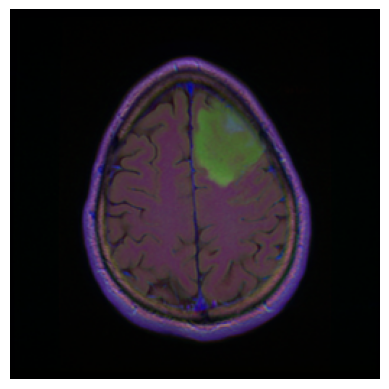

Predicted Mask:


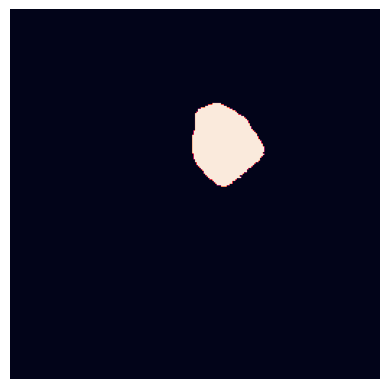

In [ ]:
import random

# Select a random index from the test set
ix = random.randint(0, len(preds_test_t) - 1)

# Display the input image
print("Input Image:")
display_images(X_test[ix])

# Display the predicted mask
print("Predicted Mask:")
display_images(np.squeeze(preds_test_t[ix]))

12/12 [==============================] - 1s 50ms/step


Validation Input Image:


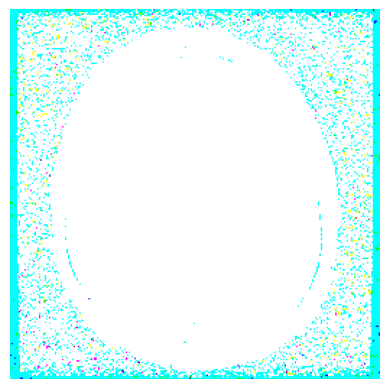

Validation Ground Truth Mask:


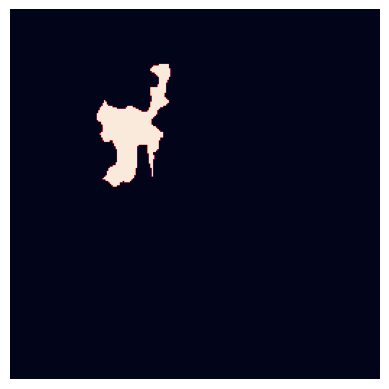

Validation Predicted Mask:


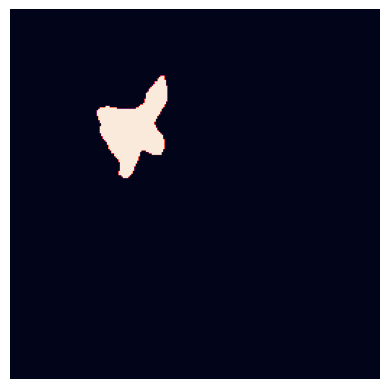

In [ ]:
import random

# Assuming preds_val_t is calculated previously
# Calculate preds_val_t
preds_val_t = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_val_t = (preds_val_t > 0.5).astype(np.uint8)

# Select a random index from the validation set
ix = random.randint(0, len(preds_val_t) - 1)

# Calculate the index from where validation data starts
val_data_start = int(X_train.shape[0] * 0.9)

# Display the validation input image
print("Validation Input Image:")
display_images(X_train[val_data_start:][ix])

# Display the validation ground truth mask
print("Validation Ground Truth Mask:")
display_images(np.squeeze(Y_train[val_data_start:][ix]))

# Display the validation predicted mask
print("Validation Predicted Mask:")
display_images(np.squeeze(preds_val_t[ix]))